In [1]:
import pandas as pd
import numpy as np
import elapid
from elapid import MaxentModel
import xarray as xr
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import joblib
import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling

In [18]:
X_train = pd.read_csv("/cluster/home/maikents/sinmod_features_masters/ready_for_training/X_train.csv")
X_test = pd.read_csv("/cluster/home/maikents/sinmod_features_masters/ready_for_training/X_test.csv")
y_train = pd.read_csv("/cluster/home/maikents/sinmod_features_masters/ready_for_training/y_train.csv")
y_test = pd.read_csv("/cluster/home/maikents/sinmod_features_masters/ready_for_training/y_test.csv")

In [2]:
combined_df_nans = pd.read_parquet("/cluster/home/maikents/sinmod_features_masters/dataframes_pipeline_1/total_df_with_nans_and_labels.parquet")


NB!!! For de andre pipelinene: spatial block cv!!! ikke 10-fold 

In [5]:
#Set up and run GridSearchCV for MaxEnt

model = elapid.MaxentModel()
param_grid = {
    'beta_multiplier': [0.5, 1.0, 2.0, 3.0, 4.0],
    'beta_hinge': [0.5, 1.0, 1.5, 2.0],
    'beta_threshold': [0.5, 1.0, 1.5, 2.0]
}

#Perform Grid Search CV
cv_model = GridSearchCV(
    model, param_grid, 
    scoring={
        'ROC': make_scorer(roc_auc_score, needs_proba=True)
    }, 
    refit='ROC', 
    cv=10,
    return_train_score=True
)
cv_model.fit(X_train, y_train)

/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/cluster/home

GridSearchCV(cv=10, estimator=MaxentModel(),
             param_grid={'beta_hinge': [0.5, 1.0, 1.5, 2.0],
                         'beta_multiplier': [0.5, 1.0, 2.0, 3.0, 4.0],
                         'beta_threshold': [0.5, 1.0, 1.5, 2.0]},
             refit='ROC', return_train_score=True,
             scoring={'ROC': make_scorer(roc_auc_score, response_method='predict_proba')})

In [7]:
joblib.dump(cv_model, '/cluster/home/maikents/maxent_model_pipeline_1.pkl')

['/cluster/home/maikents/maxent_model_pipeline_1.pkl']

In [16]:
cv_model = joblib.load('/cluster/home/maikents/maxent_model_pipeline_1.pkl')

In [19]:
#Evaluate the test performance
best_model = cv_model.best_estimator_

y_test_pred = best_model.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_test_pred)

print(f"Test AUC: {auc_score:.3f}")
print("Best regularization parameters found:", cv_model.best_params_)

Test AUC: 0.912
Best regularization parameters found: {'beta_hinge': 0.5, 'beta_multiplier': 0.5, 'beta_threshold': 0.5}


In [9]:
#Predict probabilities on the training set
y_train_pred = best_model.predict_proba(X_train)[:, 1]

train_auc_score = roc_auc_score(y_train, y_train_pred)

print(f"Train AUC: {train_auc_score:.3f}")

Train AUC: 0.946


In [10]:
#Predict across full model area 
x_coords = combined_df_nans['x']
y_coords = combined_df_nans['y']
features_only = combined_df_nans.drop(columns=['x', 'y', 'labels'], errors='ignore')
X_grid_clean = features_only.dropna()
valid_idx = X_grid_clean.index

chunk_size = 2000
num_chunks = int(np.ceil(len(X_grid_clean) / chunk_size))
predicted_probabilities_list = []

for i in range(num_chunks):
    start = i * chunk_size
    end = min((i + 1) * chunk_size, len(X_grid_clean))
    chunk = X_grid_clean.iloc[start:end]
    probs = best_model.predict_proba(chunk)[:, 1]
    predicted_probabilities_list.append(probs)

predicted_probs = np.concatenate(predicted_probabilities_list)


In [11]:
all_probabilities = np.full((len(combined_df_nans),), np.nan)

all_probabilities[valid_idx] = predicted_probs

num_x = len(np.unique(x_coords))
num_y = len(np.unique(y_coords))

In [12]:
sorted_idx = np.lexsort((x_coords, y_coords))  
all_probs_sorted = all_probabilities[sorted_idx]

In [13]:
predicted_grid = all_probs_sorted.reshape((num_y, num_x))

In [25]:
np.save("/cluster/home/maikents/sinmod_features_masters/predicted_probabilities_pipeline1.npy", predicted_grid)


In [22]:
predicted_probabilities_grid = np.load("/cluster/home/maikents/sinmod_features_masters/predicted_probabilities_pipeline1.npy")

In [20]:
coral_filepath_emod = '/cluster/home/maikents/features_midnor_2019/coral_data/midnor_coral_data_emod_grid.parquet'
coral_data_emod = pd.read_parquet(coral_filepath_emod)

In [21]:
coral_x = coral_data_emod['x']
coral_y = coral_data_emod['y']

In [34]:
print(type(predicted_probabilities_grid))

<class 'numpy.ndarray'>


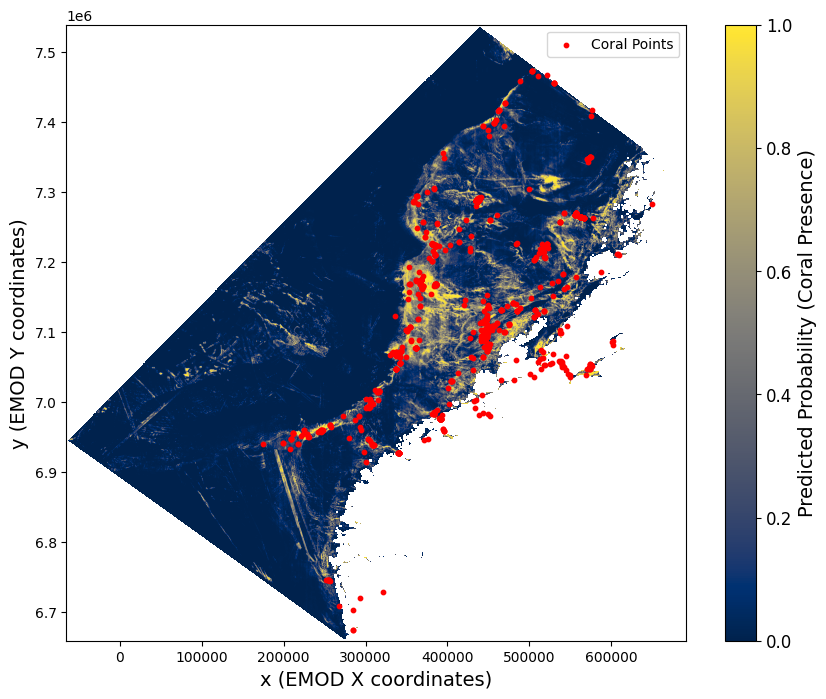

In [38]:
plt.figure(figsize=(10, 8))

img = plt.imshow(
    predicted_probabilities_grid,
    cmap= 'cividis',#'coolwarm',#'Blues',
    origin='lower',  # flip y-axis if needed
    extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
    aspect='auto'
)

cbar = plt.colorbar(img)
cbar.set_label('Predicted Probability (Coral Presence)', fontsize=14)
cbar.ax.tick_params(labelsize=12) 
plt.xlabel("x (EMOD X coordinates)", fontsize=14)
plt.ylabel("y (EMOD Y coordinates)", fontsize=14)

plt.scatter(coral_x, coral_y, color='red', s=10, label='Coral Points')

plt.legend()
plt.savefig("coral_prediction_map_corals.png", dpi=300, bbox_inches='tight')

plt.show()


In [40]:
res_x = (x_coords.max() - x_coords.min()) / predicted_probabilities_grid.shape[1]
res_y = (y_coords.max() - y_coords.min()) / predicted_probabilities_grid.shape[0]

transform = from_origin(x_coords.min(), y_coords.max(), res_x, res_y)

#Save to GeoTIFF with correct CRS
with rasterio.open(
    "/cluster/home/maikents/sinmod_features_masters/coral_prediction_emodnet_pipeline_1.tif",
    "w",
    driver="GTiff",
    height=predicted_probabilities_grid.shape[0],
    width=predicted_probabilities_grid.shape[1],
    count=1,
    dtype="float32",
    crs="EPSG:25833",  #EMODnet UTM Zone 33N / ETRS89
    transform=transform,
) as dst:
    dst.write(predicted_probabilities_grid.astype("float32"), 1)


In [2]:

with rasterio.open("/cluster/home/maikents/sinmod_features_masters/coral_prediction_emodnet_pipeline_1.tif") as src:
    data = src.read(1)  

    flipped_data = np.fliplr(data)

    meta = src.meta

    meta.update({"driver": "GTiff", "count": 1})

    with rasterio.open('/cluster/home/maikents/sinmod_features_masters/coral_prediction_emodnet_pipeline_1_flipped.tif', 'w', **meta) as dst:
        dst.write(flipped_data, 1) 

print("The raster has been flipped and saved as 'flipped_file.tif'.")


The raster has been flipped and saved as 'flipped_file.tif'.


In [2]:

with rasterio.open("/cluster/home/maikents/sinmod_features_masters/coral_prediction_emodnet_pipeline_1.tif") as src:
    data = src.read(1)

    flipped_data = np.flipud(data)

    meta = src.meta.copy()

    with rasterio.open('/cluster/home/maikents/sinmod_features_masters/coral_prediction_emodnet_pipeline_1_flipped_vertically.tif', 'w', **meta) as dst:
        dst.write(flipped_data, 1)

print("Vertical flip complete. File saved as 'flipped_vertical.tif'.")


Vertical flip complete. File saved as 'flipped_vertical.tif'.


In [2]:

with rasterio.open('/cluster/home/maikents/sinmod_features_masters/coral_prediction_emodnet_pipeline_1_flipped_vertically.tif') as src:
    data = src.read(1)
    profile = src.profile

# Replace NaNs with -9999
data_clean = np.where(np.isnan(data), -9999, data)

# Update NoData value in metadata
profile.update(nodata=-9999)

with rasterio.open('/cluster/home/maikents/sinmod_features_masters/coral_prediction_clean_pipeline1.tif', "w", **profile) as dst:
    dst.write(data_clean, 1)
